# Dask DataFrame (1)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Dask DataFrame"
* https://docs.dask.org/en/latest/dataframe.html
* Jesse C. Daniel. Data Science with Python and Dask. 

* https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.memory_usage_per_partition.html#dask.dataframe.DataFrame.memory_usage_per_partition
* https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.map_partitions.html#dask.dataframe.DataFrame.map_partitions
* https://docs.dask.org/en/stable/generated/dask.array.histogram.html
* https://docs.dask.org/en/stable/dataframe-categoricals.html
* https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.pivot_table.html#dask.dataframe.DataFrame.pivot_table

* https://docs.dask.org/en/stable/best-practices.html
* https://docs.dask.org/en/stable/dashboard.html
* https://distributed.dask.org/en/stable/client.html

## Задачи для совместного разбора

1\. Создать `dask.DataFrame`. Рассмотреть основные возможности (выбор строк, работа с датами, добавление столбцов)

In [1]:
import dask
import dask.dataframe as dd
import pandas as pd

In [3]:
df = dask.datasets.timeseries(start="2023-05-04", end="2023-05-06")
df

,name,id,x,y
npartitions=2,,,,
2023-05-04,object,int32,float64,float64
2023-05-05,...,...,...,...
2023-05-06,...,...,...,...


In [4]:
df.head(3)

,name,id,x,y
timestamp,,,,
2023-05-04 00:00:00,Zelda,957,-0.946745,-0.933016
2023-05-04 00:00:01,Bob,970,-0.882114,0.997007
2023-05-04 00:00:02,Laura,990,-0.749043,0.554917


In [5]:
zeldas = df[df['name'] == 'Zelda']
zeldas.head(5)

,name,id,x,y
timestamp,,,,
2023-05-04 00:00:00,Zelda,957,-0.946745,-0.933016
2023-05-04 00:00:27,Zelda,1006,-0.611321,0.508446
2023-05-04 00:00:52,Zelda,946,0.608013,-0.840355
2023-05-04 00:01:03,Zelda,986,0.344307,-0.633338
2023-05-04 00:02:49,Zelda,972,-0.004935,-0.638098


In [7]:
df.query("name == 'Zelda'").head(3)

,name,id,x,y
timestamp,,,,
2023-05-04 00:00:00,Zelda,957,-0.946745,-0.933016
2023-05-04 00:00:27,Zelda,1006,-0.611321,0.508446
2023-05-04 00:00:52,Zelda,946,0.608013,-0.840355


In [8]:
df.index

Dask Index Structure:
npartitions=2
2023-05-04    datetime64[ns]
2023-05-05               ...
2023-05-06               ...
Name: timestamp, dtype: datetime64[ns]
Dask Name: make-timeseries-index, 2 graph layers

In [9]:
df.index.dt.year.head(3)

Int64Index([2023, 2023, 2023], dtype='int64', name='timestamp')

In [10]:
df['key'] = df['name'].map(lambda x: x[0])
df

,name,id,x,y,key
npartitions=2,,,,,
2023-05-04,object,int32,float64,float64,object
2023-05-05,...,...,...,...,...
2023-05-06,...,...,...,...,...


In [11]:
df['name'].unique().compute()

0        Zelda
1          Bob
2        Laura
3       Yvonne
4       Ingrid
5      Norbert
6       Victor
7        Frank
8      Charlie
9       Ursula
10      Oliver
11       Kevin
12         Tim
13       Wendy
14         Dan
15       Sarah
16      Xavier
17       Edith
18      Hannah
19       Jerry
20     Michael
21       Alice
22         Ray
23    Patricia
24       Quinn
25      George
Name: name, dtype: object

2\. Используя метод pipe, добавьте столбец с полом человека и нормализуйте столбцы x и y

In [14]:
def add_key(df):
    df['key'] = df['name'].map(lambda x: x[0])
    return df

def add_gender(df):
    df['gender'] = "f"
    males = {'Norbert', 'Ray', 'Kevin'}
    df["gender"] = df["gender"].mask(df["name"].isin(males), 'm')
    return df

def normalize(df, colname):
    df[colname] = df[colname] / df[colname].max()
    return df

In [18]:
df_t = df.pipe(add_key).pipe(add_gender).pipe(normalize, colname="x").pipe(normalize, colname="y")
df_t.head()

,name,id,x,y,key,gender
timestamp,,,,,,
2023-05-04 00:00:00,Zelda,957,-0.946746,-0.933022,Z,f
2023-05-04 00:00:01,Bob,970,-0.882115,0.997013,B,f
2023-05-04 00:00:02,Laura,990,-0.749044,0.554921,L,f
2023-05-04 00:00:03,Yvonne,1041,-0.294997,-0.239525,Y,f
2023-05-04 00:00:04,Ingrid,1071,0.691719,0.757072,I,f


3\. При помощи сводных таблиц посчитайте для каждой пары (gender, key) среднее значение по столбцу x.

In [21]:
#df_t["gender"] = df_t["gender"].astype("category").cat.as_known()
df_t["gender"] = df_t["gender"].astype("category").cat.set_categories(
    ["m", "f"]
)
df_t

,name,id,x,y,key,gender
npartitions=2,,,,,,
2023-05-04,object,int32,float64,float64,object,category[known]
2023-05-05,...,...,...,...,...,...
2023-05-06,...,...,...,...,...,...


In [23]:
df_t.pivot_table(
    index="key",
    columns="gender",
    values="x",
    aggfunc="mean"
).compute()

gender,m,f
key,,
A,NaN,0.008355
B,NaN,0.007428
C,NaN,-0.002431
D,NaN,0.001331
E,NaN,0.004084
F,NaN,0.007201
G,NaN,0.003177
H,NaN,-0.005601
I,NaN,-0.000595


## Лабораторная работа 12

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.DataFrame` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.DataFrame` к `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.DataFrame` (то есть то, что было получено до вызова `compute`, а не после).

In [3]:
import dask.dataframe as dd

<p class="task" id="1"></p>

1\. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты. Выведите на экран информацию о количестве сегментов и типе столбцов. Выведите на экран 5 первых и 5 последних строк таблицы. В случае сообщения об ошибке объясните причину и исправьте ошибку.

In [31]:
recipes = dd.read_csv('recipes_full/recipes_full_*.csv', parse_dates=['submitted'])
recipes.head() # первые 5

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970,vant ivoire mickies nothing,33,803776,2019-08-22,4,pat and gina neely and their family own and op...,9
1,1089012,kremsils mariposa baccala cookies class borage...,23,51579,2013-03-02,1,"a light, tasty and easy to put together chicke...",5
2,1428572,tania lander,0,68884,1980-11-09,1,a delicious melt in your mouth appetizer. for ...,5
3,1400250,heloise milli asher doogh zojirushi,24,678862,2018-04-29,3,delicious cream cheese and peach filled cresce...,1
4,387709,nutty chocolate chunk cookies,47,489552,2009-08-31,8,everyone loves these buttery cookies chock ful...,10


In [35]:
recipes.shape

(Delayed('int-451db380-e74f-4920-ba83-764cba0b3775'), 8)

In [32]:
recipes.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+---------+---------+----------+
| Column  | Found   | Expected |
+---------+---------+----------+
| minutes | float64 | int64    |
| n_steps | float64 | int64    |
+---------+---------+----------+

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'minutes': 'float64',
       'n_steps': 'float64'}

to the call to `read_csv`/`read_table`.

Alternatively, provide `assume_missing=True` to interpret
all unspecified integer columns as floats.

В процессе определения типа данных в столбцах было "просмотрено" огранниченное количество данных, из-за чего был сделан не совсем правильный вывод обо всех данных в столбцах. 

In [4]:
recipes = dd.read_csv('recipes_full/recipes_full_*.csv', parse_dates=['submitted'],assume_missing=True)

In [59]:
recipes.tail()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
278949,1029131.0,tuti waffle snackies steakhouse,19.0,171345.0,1973-10-18,4.0,"according to a providence journal article, ama...",4.0
278950,1700703.0,noelias cheats crocante fleisch zitumbuwa,1.0,30228.0,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1.0
278951,1910650.0,rubbed restuffed pelmeni bedouin flavourful,60.0,591905.0,2009-09-26,3.0,another great recipe to add to the growing swe...,2.0
278952,713836.0,stems polpettine peezi,NaN,357389.0,2003-09-30,4.0,adapted from top secret recipes. love this!,9.0
278953,660699.0,clementines,64.0,29196.0,1973-06-03,6.0,this would make a great start to your holiday ...,8.0


In [60]:
recipes.npartitions

8

In [61]:
recipes.dtypes

id                       float64
name                      object
minutes                  float64
contributor_id           float64
submitted         datetime64[ns]
n_steps                  float64
description               object
n_ingredients            float64
dtype: object

<p class="task" id="2"></p>

2\. Выведите на экран следующую информацию:
* количество сегментов в таблице
* объем используемой памяти каждого сегмента
* количество строк в каждом сегменте
* количество строк во всей таблице.

In [62]:
recipes.npartitions

8

In [63]:
recipes.memory_usage_per_partition().compute() # в байтах

0    17853248
1    17853248
2    17853248
3    17853248
4    17853248
5    17853184
6    17853184
7    17853184
dtype: int64

In [65]:
recipes.map_partitions(len).compute()

0    278955
1    278955
2    278955
3    278955
4    278955
5    278954
6    278954
7    278954
dtype: int64

In [44]:
recipes.shape

(Delayed('int-6ad8be41-00aa-4124-adcd-3ec1b20cb30a'), 8)

In [45]:
len(recipes)

2231637

<p class="task" id="3"></p>

3\. Воспользовавшись индексатором `loc`, отберите строки фрейма `recipes`, имеющие индекс 42. Выведите полученные строки и их количество на экран. Объясните результат в виде текстового комментария.

In [69]:
rec42 = recipes.loc[42].compute()
rec42

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
42,223847.0,gyros burgers,25.0,451301.0,2007-04-21,5.0,this is a greek/american lamb and beef mixture...,11.0
42,1218643.0,zazu thisclose portage dahi,39.0,68357.0,1993-04-13,5.0,recipe is from fleischmann's breadworld.com. ...,6.0
42,265832.0,alber ensalada,35.0,1155210.0,1976-02-17,3.0,"this is a recipe i developed years back, it's ...",7.0
42,1972307.0,eclectic rigamarta bechamel bananarita chipiro...,30.0,82616.0,1996-11-29,1.0,its a a tradition in our family to have an ear...,8.0
42,1116892.0,reid pot meatza roseland trouble gougere tunes...,18.0,1389351.0,2003-07-24,3.0,this is a great dish for brunches. you can us...,8.0
42,249625.0,african peanut and ginger chicken,120.0,317934.0,2007-08-29,17.0,add precooked chicken to soup-like mixture and...,13.0
42,452814.0,pepper jack mac,45.0,174096.0,2011-04-03,7.0,a spicy twist on mac & cheese - delicious! i ...,7.0
42,1601792.0,fetasaganaki kalaloo kabos unbaked jhal decision,57.0,27678.0,1990-07-08,3.0,yummy and spicy pumpkin fudge,6.0


In [70]:
len(rec42)

8

Dask DataFrame состоит из нескольких датафреймов и в каждом есть строчка с индексом 42.

<p class="task" id="4"></p>

4\. Выясните, сколько рецептов содержат слово `chocolate` в названии (`name`). Выведите на количество уникальных идентификаторов авторов таких рецептов.

In [76]:
recipes['name'].astype(str).compute()

0                               vant ivoire mickies nothing
1         kremsils mariposa baccala cookies class borage...
2                                              tania lander
3                       heloise milli asher doogh zojirushi
4                             nutty chocolate chunk cookies
                                ...                        
278949                      tuti waffle snackies steakhouse
278950            noelias cheats crocante fleisch zitumbuwa
278951          rubbed restuffed pelmeni bedouin flavourful
278952                               stems polpettine peezi
278953                                          clementines
Name: name, Length: 2231637, dtype: object

In [20]:
choco = recipes[recipes['name'].astype(str).str.contains(r'\bchocolate\b')].shape[0].compute()
choco

9155

In [21]:
id_ = recipes[recipes['name'].astype(str).str.contains(r'\bchocolate\b')]['contributor_id'].unique().shape[0].compute()
id_

3724

<p class="task" id="5"></p>

5\. При помощи функции `da.histogram` посчитайте значения для построения гистограммы для столбца `n_ingredients`. Визуализируйте полученные результаты при помощи функции `plt.bar`. Добавьте на рисунок 2 вертикальные линии, соответствующие квантилям уровней 0.25 и 0.75. Сделайте масштаб вертикальной оси логарифмическим.

Допускается вычисление статистики по столбцу (применение метода `compute`) до того, как будет вызван `da.histogram`. 

In [5]:
import matplotlib.pyplot as plt
import dask.array as da

In [6]:
hist, bins = da.histogram(recipes['n_ingredients'], 
                          bins=100,
                          range=(recipes['n_ingredients'].min(), recipes['n_ingredients'].max()))

In [9]:
hist, bins = dask.compute(hist, bins)

In [10]:
q1 = recipes['n_ingredients'].quantile(0.25)
q3 = recipes['n_ingredients'].quantile(0.75)
q1, q3 = dask.compute(q1, q3)

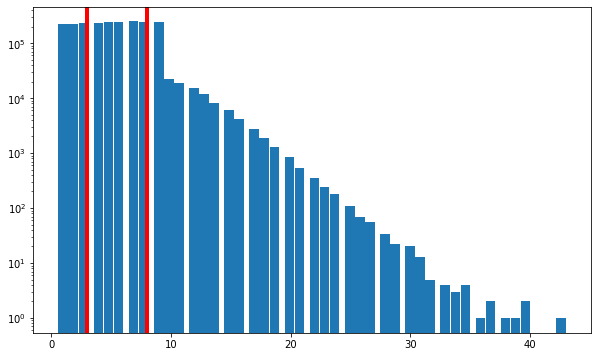

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, log=True)
plt.axvline(q1, color='r', linewidth=4)
plt.axvline(q3, color='r', linewidth=4);

<p class="task" id="6"></p>

6\. Напишите функции:
* `minutes_to_hours(df)`, которая принимает на вход фрейм и заменяет столбец `minutes` на столбец `hours` с соответствующим преобразованием чисел;
* `extract_ymd(df)`, которая добавляет 3 столбца: `year`, `month` и `day`, полученные на основе столбца `submitted`;
* `add_month_name(df)`, которая добавляет категориальный столбец `month_name` с названием месяца из даты и вызывает для него метод `.cat.as_known()`. 

Создайте фрейм `recipes_pipe` путем цепочки вызовов метода `pipe` с применением данных функций. Выведите на экран строку, соответствующую рецепту с id=683970. Для отбора строки воспользуйтесь методом `query`.

In [5]:
def minutes_to_hours(df):
    df['hours'] = df['minutes'] / 60
    df = df.drop('minutes', axis=1)
    return df

def extract_ymd(df):
    df['year'] = df['submitted'].dt.year
    df['month'] = df['submitted'].dt.month
    df['day'] = df['submitted'].dt.day
    return df

def add_month_name(df):
    col = df['submitted'].dt.strftime('%B')
    df['month_name'] = col.astype("category").cat.as_known()
    return df

In [6]:
recipes_pipe = recipes.pipe(minutes_to_hours).pipe(extract_ymd).pipe(add_month_name)

In [45]:
recipes_pipe.query("id == 683970").compute()

,id,name,contributor_id,submitted,n_steps,description,n_ingredients,hours,year,month,day,month_name
0,683970.0,vant ivoire mickies nothing,803776.0,2019-08-22,4.0,pat and gina neely and their family own and op...,9.0,0.55,2019,8,22,August


<p class="task" id="7"></p>

7\. Используя результат предыдущей задачи, постройте сводную таблицу при помощи метода `pivot_table`, где по строкам располагаются года, по столбцам - названия месяцев, а в ячейках содержится средняя длина рецептов (в часах) в данный год и месяц. Выведите таблицу на экран. Выведите на экран информацию за апрель 1970-1975 годов (включительно).

In [8]:
pt = recipes_pipe.pivot_table(
    index="year",
    columns="month_name",
    values="hours",
    aggfunc="mean"
)
pt.compute()

month_name,April,August,December,February,January,July,June,March,May,November,October,September
year,,,,,,,,,,,,
1970,0.535253,0.544904,0.535515,0.531530,0.532693,0.542781,0.544243,0.528301,0.536688,0.537969,0.532659,0.538930
1971,0.547731,0.530590,0.543796,0.533528,0.533237,0.545502,0.536644,0.535626,0.529507,0.531603,0.542461,0.545521
1972,0.531383,0.543788,0.540724,0.527673,0.527548,0.539933,0.530001,0.543361,0.539681,0.545566,0.536516,0.542677
1973,0.533646,0.546603,0.542902,0.538645,0.539917,0.530634,0.535194,0.533162,0.534956,0.538673,0.535226,0.528227
1974,0.540382,0.528316,0.535279,0.539811,0.535436,0.542733,0.532864,0.540594,0.542213,0.537463,0.536957,0.536616
1975,0.535514,0.534260,0.534445,0.533850,0.543938,0.538529,0.534805,0.539711,0.530531,0.541481,0.529238,0.548624
1976,0.543596,0.536620,0.532532,0.534188,0.548785,0.540760,0.528133,0.538327,0.537886,0.532967,0.540424,0.542933
1977,0.534943,0.536607,0.541353,0.537868,0.531178,0.542600,0.538966,0.532360,0.533895,0.536143,0.529759,0.531099
1978,0.536417,0.540905,0.540035,0.533373,0.538842,0.539100,0.539322,0.529556,0.537688,0.534920,0.545526,0.545815


In [34]:
pt['April'][1970:1975].compute()

year
1970    0.535253
1971    0.547731
1972    0.531383
1973    0.533646
1974    0.540382
1975    0.535514
Name: April, dtype: float64

<p class="task" id="8"></p>

8\. В архиве `recipes_additional.zip` находятся файлы, содержащие информацию об рецептах блюд, полученные из другого источника. В связи с этим названия и количество столбцов в этих данных отличаются от того, что находится в архиве `recipes_full.zip`.

Объедините два набора набора данных (добавьте строки из одного набора данных к другому), согласовав названия столбцов и форматы данных. Итоговый фрейм должен содержать следующие колонки: `id`, `name`, `minutes`, `contributor_id`, `submitted`, `n_steps`, `description`, `n_ingredients`, `#tags` и `view_30_days`. Добавьте столбец `dset` с информацией о том, из какого датасета была получены данные.

Выведите на экран количество пропусков в каждом из столбцов полученной таблицы и общее количество строк в ней.

In [79]:
r0 = dd.read_csv('recipes_additional/recipes_additional_0.csv', assume_missing=True)
r0.columns

Index(['name', 'description', 'hours', 'date_of_publication', '#tags',
       '#ingredients', 'recipe_id', 'views_30_days'],
      dtype='object')

In [80]:
###
r1 = dd.read_csv('recipes_additional/recipes_additional_1.csv', assume_missing=True).drop(['minutes', 'n_steps'], axis=1)
r1.columns

Index(['name', 'description', 'hours', 'date_of_publication', '#tags',
       '#ingredients', 'recipe_id', 'views_30_days'],
      dtype='object')

In [81]:
r2 = dd.read_csv('recipes_additional/recipes_additional_2.csv', assume_missing=True)
r2.columns

Index(['name', 'description', 'hours', 'date_of_publication', '#tags',
       '#ingredients', 'recipe_id', 'views_30_days'],
      dtype='object')

In [82]:
###
r3 = dd.read_csv('recipes_additional/recipes_additional_3.csv', assume_missing=True).drop(['minutes', 'n_steps'], axis=1)
r3.columns

Index(['name', 'description', 'hours', 'date_of_publication', '#tags',
       '#ingredients', 'recipe_id', 'views_30_days'],
      dtype='object')

In [83]:
r4 = dd.read_csv('recipes_additional/recipes_additional_4.csv', assume_missing=True)
r4.columns

Index(['name', 'description', 'hours', 'date_of_publication', '#tags',
       '#ingredients', 'recipe_id', 'views_30_days'],
      dtype='object')

In [84]:
recipes_add = dd.concat([r0, r1, r2, r3, r4])
recipes_add.head()

,name,description,hours,date_of_publication,#tags,#ingredients,recipe_id,views_30_days
0,blue cheese tenders,found this recipe in my mom's older recipes. ...,0.333333,01/02/2008,12.0,5.0,52604,2001.0
1,hindi frappes tikkis siro changling anya jerkll,this is one i found on a post-it in my kitchen...,0.550000,25/06/1983,13.0,3.0,1ef55e,4691.0
2,navratan padma beehoon contest carrot,ok...here in the us avocados are used in savor...,0.433333,19/12/2007,9.0,5.0,6ccf2,3823.0
3,camptown two hurry laddi,i got this out of southern living magazine and...,0.133333,06/11/1998,3.0,4.0,6bb49,3202.0
4,down on the farm sausage bake,definite comfort food for me and my family.,1.250000,16/10/2002,5.0,13.0,dd23,2143.0


In [86]:
recipes_add['date_of_publication'] = dd.to_datetime(recipes_add['date_of_publication'], format='%d/%m/%Y')
recipes_add['hours'] = recipes_add['hours'].apply(lambda x: x * 60, meta=('hours', 'float64'))
recipes_add = recipes_add.rename(
    columns={'hours':'minutes', 'date_of_publication':'submitted', 'recipe_id':'id', '#ingredients':'n_ingredients'}
)
recipes_add['dset'] = 'recipes_additional'
recipes_add.head()

,name,description,minutes,submitted,#tags,n_ingredients,id,views_30_days,dset
0,blue cheese tenders,found this recipe in my mom's older recipes. ...,20.0,2008-02-01,12.0,5.0,52604,2001.0,recipes_additional
1,hindi frappes tikkis siro changling anya jerkll,this is one i found on a post-it in my kitchen...,33.0,1983-06-25,13.0,3.0,1ef55e,4691.0,recipes_additional
2,navratan padma beehoon contest carrot,ok...here in the us avocados are used in savor...,26.0,2007-12-19,9.0,5.0,6ccf2,3823.0,recipes_additional
3,camptown two hurry laddi,i got this out of southern living magazine and...,8.0,1998-11-06,3.0,4.0,6bb49,3202.0,recipes_additional
4,down on the farm sausage bake,definite comfort food for me and my family.,75.0,2002-10-16,5.0,13.0,dd23,2143.0,recipes_additional


In [32]:
recipes['dset'] = 'recipes'

In [88]:
recipes_total = dd.concat([recipes, recipes_add])
recipes_total.head()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients,dset,#tags,views_30_days
0,683970.0,vant ivoire mickies nothing,33.0,803776.0,2019-08-22,4.0,pat and gina neely and their family own and op...,9.0,recipes,NaN,NaN
1,1089012.0,kremsils mariposa baccala cookies class borage...,23.0,51579.0,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5.0,recipes,NaN,NaN
2,1428572.0,tania lander,0.0,68884.0,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5.0,recipes,NaN,NaN
3,1400250.0,heloise milli asher doogh zojirushi,24.0,678862.0,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1.0,recipes,NaN,NaN
4,387709.0,nutty chocolate chunk cookies,47.0,489552.0,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10.0,recipes,NaN,NaN


In [90]:
recipes_total.isna().sum().compute()

id                      0
name                   23
minutes             15871
contributor_id    1629095
submitted               0
n_steps           1629095
description         82965
n_ingredients           0
dset                    0
#tags             2231637
views_30_days     2231637
dtype: int64

In [91]:
recipes_total.shape[0].compute()

3860732